<a href="https://colab.research.google.com/github/yardsale8/probability_simulations_in_R/blob/main/1_6_plotting_estimated_distributions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
library(tidyverse)
library(devtools)
install_github('yardsale8/purrrfect', force = TRUE)
library(purrrfect)

# Plotting and Summarizing Simulated Distributions

In this notebook, we will look as stacking the results of simple and parametric simulations to allow for tabulating and summarizing the resulting distribution.

## Plotting the Estimated Distrubiton

Stacking the outcomes, will allow us to plot the estimated distributions, using either

1. The estimated probability mass function,
2. The estimated cumulative distribution function (CDF), or
3. Comparing the observed and theoretical distributions with a probability-probability (p-p) plot.

### Review - Probability mass function (PMF)

Let $X$ be a discrete random variable, the the **probability mass function (PMF)** is given by

$$p(x) = P(X = x)$$

for all $x\in \mathbb{R}$.

#### Example - Plotting the PMF for a waiting time problem.

Suppose that are are rolling a fair, 6-sided die until we see a roll of 5 or 6.  This is a compound--but not parametric--simultion.  Let's plote the estimated PMF

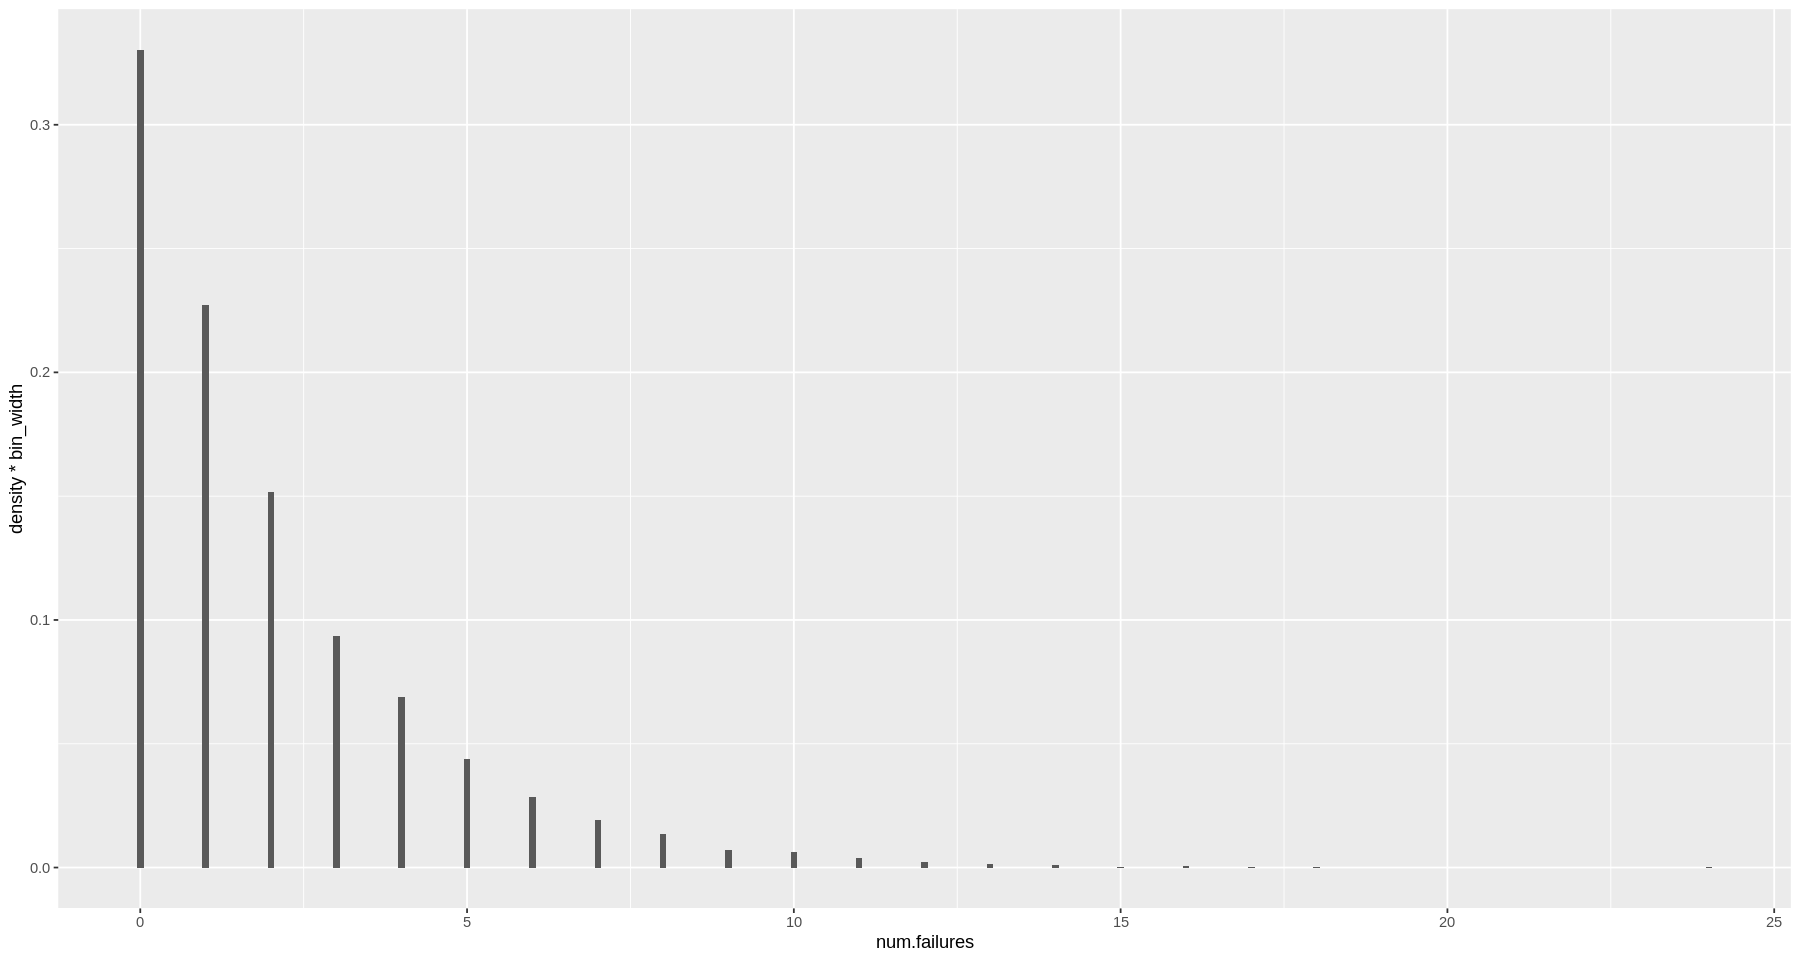

In [ ]:
is.success <- \(x) x >= 5
one.success <- \(x) num_successes(x, is.success)
die <- 1:6

bin_width <- 0.1
num.trials <- 10000
(replicate(num.trials, sample_until(die, one.success, replace=TRUE))
 %>% mutate(total.trials = map_int(.outcome, length),
            num.failures = total.trials - 1)
) -> waiting_times

ggplot(data = waiting_times,  aes(x = num.failures)) +
  geom_histogram(aes(y = stat(density) * bin_width), binwidth = bin_width)

### Review - Probability Density Function (PDF)

When $X$ is a continuous random variable, then the underlying distribution is captured by a **probability density function** and probabilites are calculated by integrating this function.

### Plotting the estimated PDF

To plot an estimated PDF with `ggplot2`, we will

1. Create a histogram mapping `x` to the observations and the height to `y=..density..`, and
2. Adding a density smoother using `geom_density`.

#### Example - Plotting gamm data.

Suppose that $Y\sim gamma(\alpha=2, \beta=3)$.  Let's simulate and plot the estimated PDF.

Warning message:
“The dot-dot notation (`..density..`) was deprecated in ggplot2 3.4.0.
ℹ Please use `after_stat(density)` instead.”


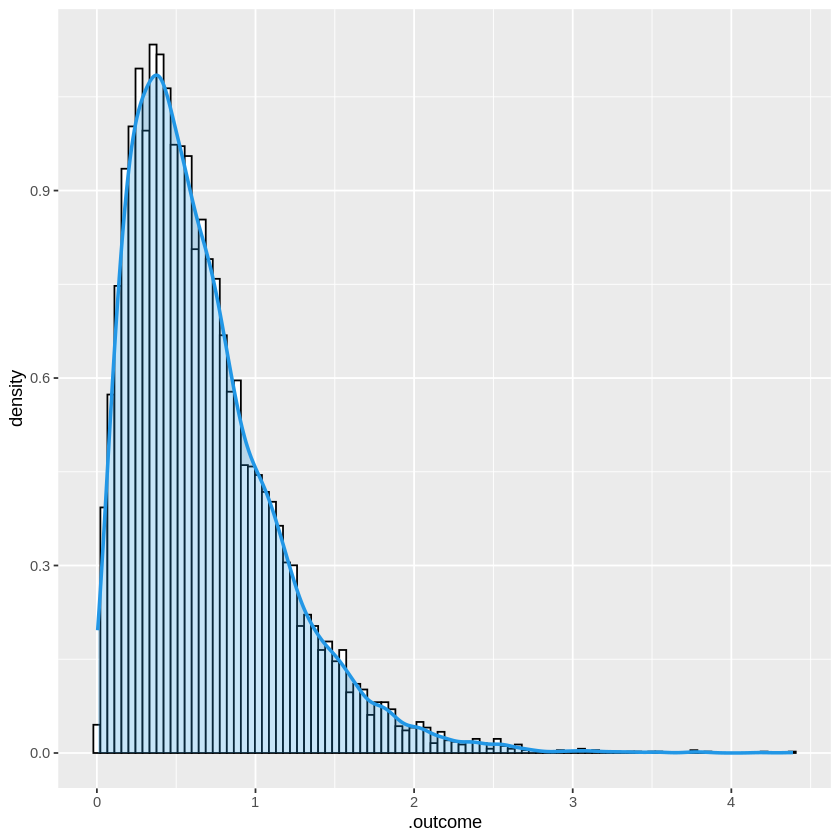

In [4]:
a <- 2
b <- 3
num_trials <- 10000
(replicate_dbl(num_trials, rgamma(1, 2, 3))
) -> gamma_simulation

ggplot(data = gamma_simulation, (aes(x = .outcome))) +
  geom_histogram(aes(y = ..density..), bins = 100, color = 1, fill="white") +
  geom_density(lwd = 1, colour = 4,
               fill = 4, alpha = 0.25)

### Plotting the CDF

Next, we will look at plotting the cumulative distribution function (CDF).  First, let's review

### Review - The cumulative distribution function (CDF)

Recall that the cumulative distribution function (CDF) of a random variable $X$ is the function $F$ such that

$$F(x) = P(X \le x)$$

 for all $x\in\mathbb{R}$.  We will be refering to this functions at the **theoretical CDF**.  



### Review -- The Empirical CDF

The **empirical CDF** is the sample estimate of said function, and is constructed by computing the fraction of the data at or below is observed value.  Let $s$ the sample represented as a multi-set (which allows for repeated values), then the **empirical CDF** is given by

$$\hat{F}(x)=\frac{1}{n}\sum_{k\in s} I(x \le k)$$.

for all $x\in\mathbb{R}$.  Here, $I$ is an [indicator function](https://en.wikipedia.org/wiki/Indicator_function), where $I(x \le k)$ will be 1 when $x \le k$, and zero otherwise.

### Computing empirical and theoretical CDFs in R

We can use the following functions to compute or estimate the CDF.

1. The window function `cume_dist` is applied to the outcome column to estimate the CDF of that point using the sample.  
2. We can compute the theoretical CDF of the outcomes by mapping the parameters + observed value onto respective R "`p`" function, such at `pbinom` or `pnorm`.

#### Discrete Example - Plotting the empirical and theoretical CDF for a waiting time problem.

The previous experiment involved rolling a fair, 6-sided die until we see a roll of 5 or 6.  If $Y$ represents the number of failures until the first success, we know that $Y\sim Geom(1/3)$ and the theoretical CDF can be computed using the `pgeom` R function.

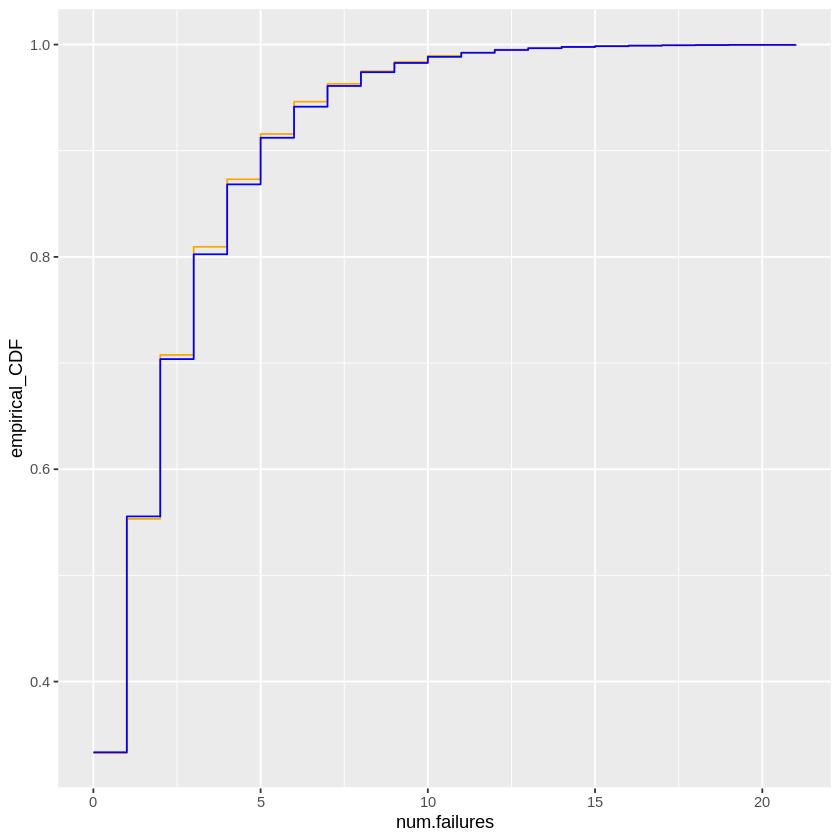

In [3]:
is.success <- \(x) x >= 5
one.success <- \(x) num_successes(x, is.success)
die <- 1:6
num.trials <- 10000
(replicate(num.trials, sample_until(die, one.success, replace=TRUE))
 %>% mutate(total.trials = map_int(.outcome, length),
            num.failures = total.trials - 1)
 %>% mutate(empirical_CDF = cume_dist(num.failures),
            theoretical_CDF = pgeom(num.failures, 1/3))
) -> waiting_times

 ggplot(data = waiting_times) +
   geom_step(aes(x = num.failures, y = empirical_CDF), color = "orange") +
   geom_step(aes(x = num.failures, y = theoretical_CDF), color = "blue")

### Creating a p-p plot

While the plots in the last example illustrated the similarity between the empirical and theoretical CDFs, the standard way of making this comparison is with a [p-p plot ](https://en.wikipedia.org/wiki/P%E2%80%93P_plot).  This is accomplished by making a scatterplot of the estimated and theoretical values of the CDF.  For convenience, we will also add the $y=x$ reference line (see below).

**Interpretation.** If the simulated data matches the theoretical distribution, $x$ and $y$ will be nearly identical and the points will be close to the reference line $y=x$.  On the other hand, if the observed data deviate from the theoretical distribution, the $x$ and $y$ values will differ and be distant from the reference line.

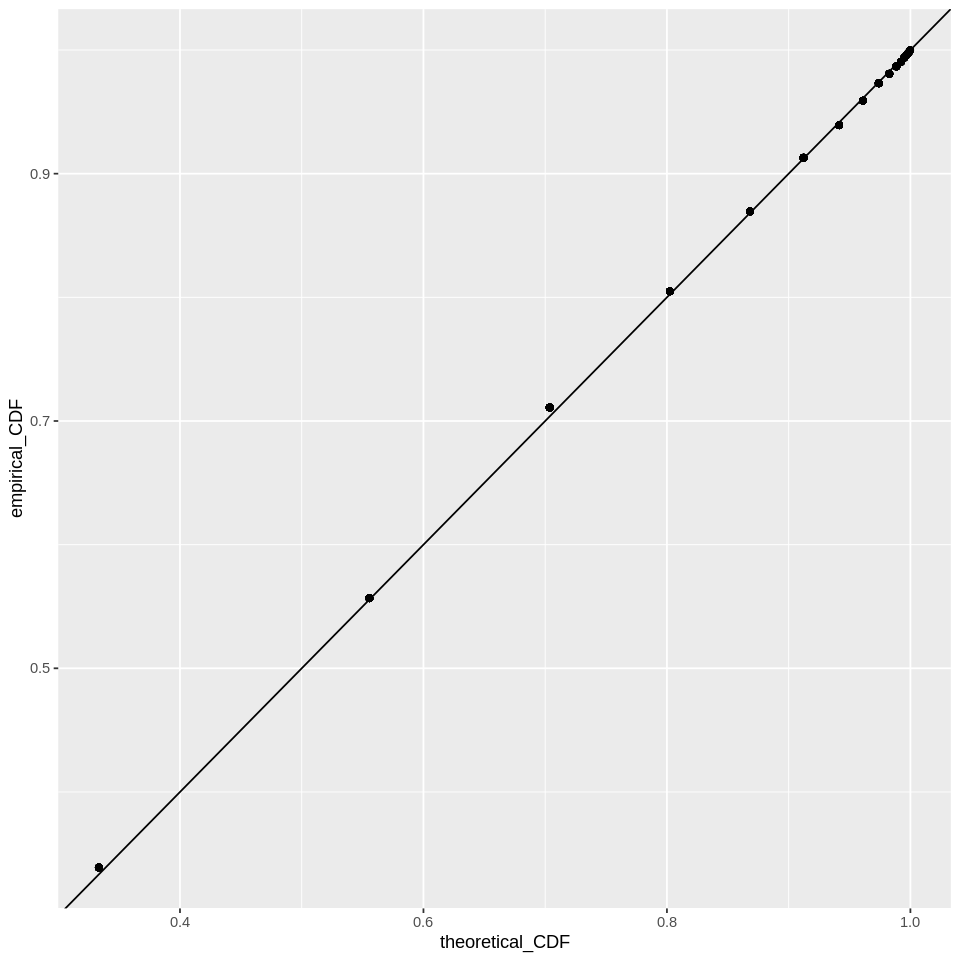

In [ ]:
ggplot(data = waiting_times) +
   geom_abline(aes(slope = 1, intercept = 0)) +
   geom_point(aes(x = theoretical_CDF, y = empirical_CDF))

#### Why use a p-p plot?

There are a few reasons to use p-p (or q-q) plot over comparing the CDFs.

1. It is generally easier to deviations from a line,
2. The task is normalized regardless of the underlying distribution, and
3. It is possible to diagnose the type of deviation (skew, long tails, etc.).

### Note on plotting a discrete and continuous CDFs

Note that
* The empirical CDF is always a step-wise function--regardless of the nature of the random variable--and should use `geom_step`,
* The theoretical CDFs for a discrete random variable is also a step-wise functions and should use `geom_step`, but
* The theoretical CDF for a continuous random variable is a continuous function can should be plotted using `geom_line`.

#### Continuous Example - Empirical vs. Theoretical CDF for the gamma distribution

Again let $Y\sim gamma(\alpha=2, \beta=3)$.  Let's compare the empirical and theoretical CDFs, both by overlaying the CDF plots and creating a p-p plot.



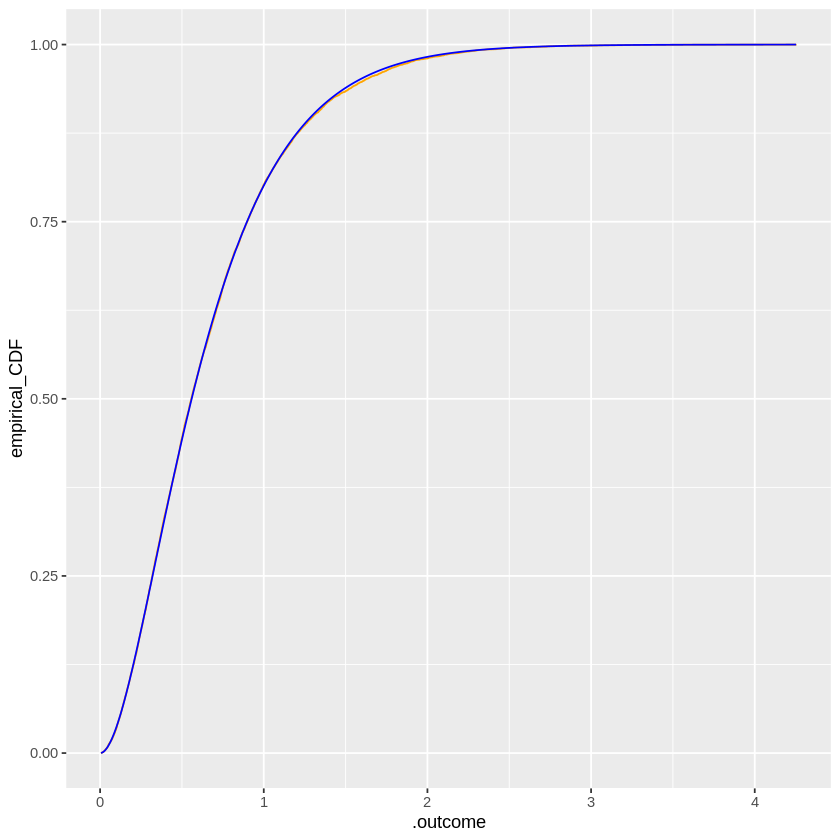

In [9]:
a <- 2
b <- 3
num_trials <- 10000
(replicate_dbl(num_trials, rgamma(1, 2, 3))
 %>% mutate(empirical_CDF = cume_dist(.outcome),
            theoretical_CDF = pgamma(.outcome, a, b))
) -> gamma_CDFs

ggplot(data = gamma_CDFs, (aes(x = .outcome))) +
   geom_step(aes(y = empirical_CDF), color = "orange") +
   geom_line(aes(y = theoretical_CDF), color = "blue")

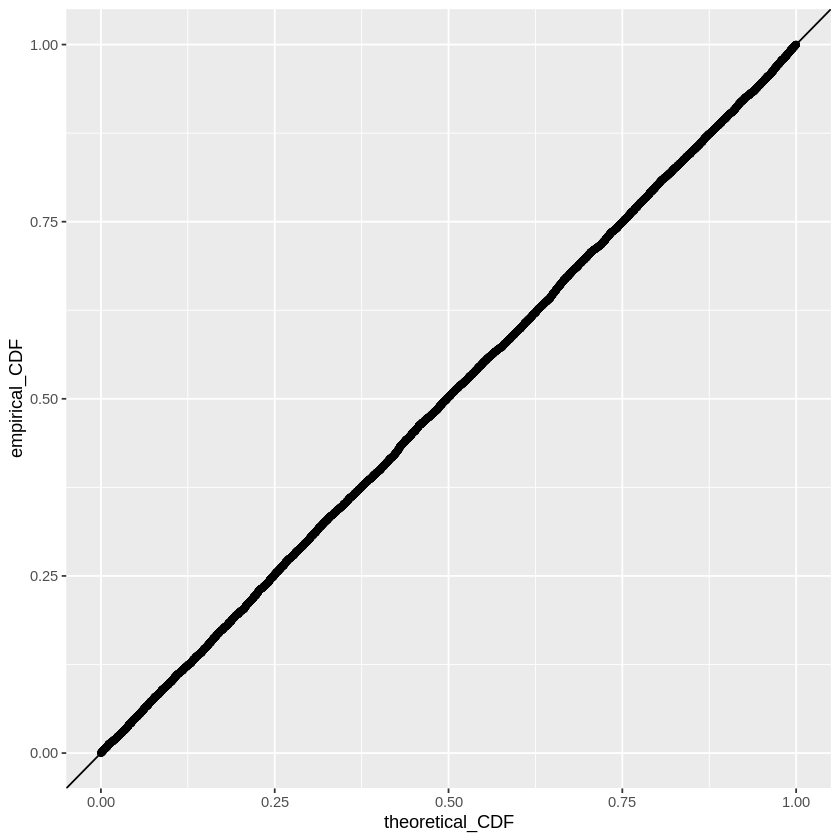

In [10]:
ggplot(data = gamma_CDFs) +
   geom_abline(aes(slope = 1, intercept = 0)) +
   geom_point(aes(x = theoretical_CDF, y = empirical_CDF))

## <font color="red"> Exercise 2.6.1 </font>

Suppose that $X$ and $Y$ are independent random variables with $X\sim gamma(\alpha = 2, \beta = 1)$ and $Y\sim gamma(\alpha = 3, \beta = 1)$.  Let $T = X + Y$.  It can be shown that $T\sim gamma(\alpha = 3 + 2, \beta = 1)$.

**Tasks.**

1. Explain why this result makes sense from a waiting time standpoint.
2. Use a simulating to verify this results by constructing all three types of plots (histogram, CDFs, and p-p plot).

<font color="orange">
Answer <b>1.</b> here.
</font>

In [ ]:
# Your code for 2. here